# Project 1

This describes the first bigger programming project in the course, devoted to artificial
neural networks.
Application: Recognizing handwritten numbers
Most people effortlessly recognise these digits as 504192. This ease is deceptive. The
difficulty of visual pattern recognition becomes obvious when trying to write a computer
program to recognise digits like the above. What seems easy when we do it ourselves
suddenly becomes extremely difficult. Simple notions about how we recognise shapes -
“a 9 has a loop at the top and a vertical line at the bottom right” - turn out to be not
so easy to express algorithmically. If you try to specify such rules, you quickly get lost
in a quagmire of exceptions, restrictions and special cases. It seems hopeless.
Neural networks approach the problem differently. The idea is to use a large number of
handwritten digits, called training examples, and then develop a system that can learn
from these training examples. In other words, the neural network uses the examples to
automatically derive rules for recognising handwritten digits. In addition, by increasing
the number of training examples, the network can learn more about handwriting and
thus improve its accuracy.

### Imports

In [47]:
# Imports
import numpy as np
# pickle is for loading the dataset
import pickle

### Feedforward NN Class

Feedforward neural network consisting of 3 layers (input,
hidden, output layer), where each layer can contain any number of neurons. Sigmoid function is used as the activation function.

Stochastic gradient method (SGD) with backpropagation to train the network.



In [59]:
# Feedforward NN Class
class FeedForwardNeuralNetwork():
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # randn was used to achieve a better initial estimate of the weights and biases by having random values from a 
        # gaussian distribution. This results in better accuracy    
        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.bias_hidden = np.random.randn(self.hidden_size)
        self.weights_output_hidden = np.random.randn(self.hidden_size, self.output_size)
        self.bias_output = np.random.randn(self.output_size)

    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    # performs the forward pass through the neural network : that is, it does matrix multiplication(np.dot) and adds the
    # biases
    def forward(self, input_data):
        hidden_input = np.dot(input_data, self.weights_input_hidden) + self.bias_hidden
        hidden_output = self.sigmoid(hidden_input)
        output = np.dot(hidden_output, self.weights_output_hidden) + self.bias_output
        network_output = self.sigmoid(output)
        return network_output, hidden_output
    

    def train_sgd(self, X_train, Y_train, X_val, Y_val_onehot, learning_rate, batch_size, epochs):
        
        """
        X_train : training samples
        Y_train : training labels
        x_val   : validation samples
        Y_val_onehot  : validation labels
        learning_rate : step size for the backpropagation
        batch_size    : the number of samples processed before the model is updated
        epochs        : the number of complete passes through the entire dataset
        
        """
        # starting value for the loss
        best_val_loss = 100
        indices = np.arange(len(X_train))

        for epoch in range(epochs):
            # Shuffle the dataset so that the batch samples are not consecutive
            np.random.shuffle(indices)
            total_loss = []

            print(f'----------epoch: {epoch}------------')

            for i in range(0, len(X_train), batch_size):
                # Create mini-batches
                batch_indices = indices[i:i+batch_size]
                X_batch = X_train[batch_indices]
                y_batch = Y_train[batch_indices]

                # Forward pass
                network_output, hidden_output = self.forward(X_batch)

                # Backpropagation
                # Calculate loss and gradients
                # quadratic function (square loss) -- 1/2n is the mean from the formula
                loss = np.mean(0.5 * (network_output - y_batch) ** 2, axis=0)
                # the loss is averaged over the multiple losses to have a prettier print
                total_loss.append(np.mean(loss))  # Average over the mini-batch

                error = network_output - y_batch
                # calculate the gradient (derivative) of the loss with respect to the output of the neural network's final layer.
                d_output = error * network_output * (1 - network_output)
                # calculate the gradient of the loss with respect to the hidden layer's activations.
                d_hidden = np.dot(d_output, self.weights_output_hidden.T) * hidden_output * (1 - hidden_output)

                # Update weights and biases
                self.weights_output_hidden -= learning_rate * np.dot(hidden_output.T, d_output)
                self.bias_output -= learning_rate * np.sum(d_output, axis=0)
                self.weights_input_hidden -= learning_rate * np.dot(X_batch.T, d_hidden)
                self.bias_hidden -= learning_rate * np.sum(d_hidden, axis=0)
                
            print(f'mean square loss: {np.mean(total_loss)}')
                # Evaluate the model on the validation set
                #maybe comment it if we dont want the validation within the training
              
        """             
            val_loss, val_accuracy = self.evaluate(X_val, Y_val_onehot) 
            print(f"Epoch {epoch+1}: Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}")
    
            # Check for early stopping or other criteria to save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                woh =  self.weights_output_hidden
                bo = self.bias_output
                wih = self.weights_input_hidden
                bh = self.bias_hidden

        # Update weights to the best weights
        self.weights_output_hidden = woh 
        self.bias_output = bo
        self.weights_input_hidden = wih
        self.bias_hidden = bh
        """

    def evaluate(self, X_val, Y_val):
        num_examples = len(X_val)
        # Forward pass on the validation data
        val_predictions = self.predict(X_val)
        # Calculate the mean loss
        val_loss = np.mean(0.5 * (val_predictions - X_val) ** 2, axis=0)

        # Convert predicted probabilities to predicted class labels (0-9)
        val_predictions_class = np.argmax(val_predictions, axis=1)
        
        # Convert true labels (one-hot encoded) to true class labels (0-9)
        Y_val_class = np.argmax(Y_val, axis=1)

        # Calculate accuracy
        val_accuracy = np.sum(val_predictions_class == Y_val_class) / num_examples

        return val_loss, val_accuracy

        
    def predict(self, input_data):
        # Perform a forward pass to generate predictions
        hidden_input = np.dot(input_data, self.weights_input_hidden) + self.bias_hidden
        hidden_output = self.sigmoid(hidden_input)
        output = np.dot(hidden_output, self.weights_output_hidden) + self.bias_output
        network_output = self.sigmoid(output)

        # Return the predicted values
        return network_output
    
    # functions to save the weights and biases in a txt file and to load it in the model
    def save_weights(self, filename):
        """
        This function saves the weights from the model in order i.e. the weights from the first layer and then second according
        to the labels given in the function call(which is before the equal)
        The file will have the .npz extension automatically if not written specifically in the filename
        """
        #probably want to save the number of neurons on each layer as well, and restore the model with load(but i thought about it a bit too late)
        np.savez(filename, weights_input_hidden=self.weights_input_hidden,
                           bias_hidden=self.bias_hidden,
                           weights_output_hidden= self.weights_output_hidden,
                           bias_output =self.bias_output)
    
    
    def load_weights(self,filename):
        """
        Loads the weights from a file. The filename should have the extension .npz in the name. The weights are loaded
        according to the labels which have been used to save it
        
        """
        all_weights = np.load(filename)
        self.weights_input_hidden = all_weights['weights_input_hidden']
        self.bias_hidden = all_weights['bias_hidden']
        self.weights_output_hidden = all_weights['weights_output_hidden']
        self.bias_output = all_weights['bias_output']


### Load Data

Reading in MNIST data (provided in canvas). The data is separated into training
data (50 000), validation data (10 000), and test data (10 000).

In [49]:
# Load MNIST data from mnist.pkl
with open('mnist.pkl', 'rb') as f:
    mnist_data = pickle.load(f, encoding='latin1')

# Extract training, validation, and test sets
train_data, valid_data, test_data = mnist_data

# Unpack the data into inputs and labels
X_train, Y_train = train_data
X_val, Y_val = valid_data
X_test, Y_test = test_data

# Convert inputs to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Convert labels to numpy arrays
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)


### Normalize 

In [50]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

### Onehot encode the labels

In [51]:
#one hot encoding - maps the numbers for all the dataset to vectors with 1s and 0s 
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
Y_train_onehot = encoder.fit_transform(Y_train.reshape(-1, 1))
Y_val_onehot = encoder.fit_transform(Y_val.reshape(-1, 1))

np.shape(Y_train_onehot), np.shape(X_train)

((50000, 10), (50000, 784))

### Training
Train and test the accuracy of the network for the following parameters:

• Input layer with 784 + 1 neurons

• hidden layer with 30 + 1 neurons

• Output layer with 10 neurons

As loss function use the quadratic function (square loss),
where (x, y) is a pair of training data, n the amount of used training data, and hw
represents the neural network.

In [52]:
nn = FeedForwardNeuralNetwork(784, 30, 10)
epochs = 100
learning_rate = 0.01
batch_size = 128
nn.train_sgd(X_train, Y_train_onehot, X_val, Y_val_onehot, learning_rate, batch_size, epochs)


----------epoch: 0------------
mean square loss: 0.043982443615386696
----------epoch: 1------------
mean square loss: 0.029812742113340424
----------epoch: 2------------
mean square loss: 0.02493963546107567
----------epoch: 3------------
mean square loss: 0.022719695581358824
----------epoch: 4------------
mean square loss: 0.021390767411668985
----------epoch: 5------------
mean square loss: 0.0204631786464621
----------epoch: 6------------
mean square loss: 0.019764385591977712
----------epoch: 7------------
mean square loss: 0.0191926315749839
----------epoch: 8------------
mean square loss: 0.01767494471495375
----------epoch: 9------------
mean square loss: 0.01562790963298855
----------epoch: 10------------
mean square loss: 0.01486294862707695
----------epoch: 11------------
mean square loss: 0.014369016148820333
----------epoch: 12------------
mean square loss: 0.013977369718327741
----------epoch: 13------------
mean square loss: 0.013662090926998731
----------epoch: 14-----

### Prediction

In [53]:
y_pred = nn.predict(X_test)
# Convert to labels (0-9)
y_pred = y_pred.argmax(axis=1)

In [54]:
y_pred, Y_test

(array([7, 2, 1, ..., 4, 5, 6]), array([7, 2, 1, ..., 4, 5, 6]))

### Accuracy

In [55]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test, y_pred)
accuracy

0.9364

### Saving and loading the model


Save weights

In [56]:
# model_name to differentiate between the different model weights
model_name = f'model_weights.epochs.{epochs}.lr.{learning_rate}.bsize.{batch_size}'
nn.save_weights(model_name)

Load weights

In [57]:
saved_nn = FeedForwardNeuralNetwork(784, 30, 10)
saved_nn.load_weights(f'{model_name}.npz')
y_pred = saved_nn.predict(X_test)
# Convert to labels (0-9)
y_pred = y_pred.argmax(axis=1)
accuracy_score(Y_test, y_pred)

0.9364

Confusion matrix

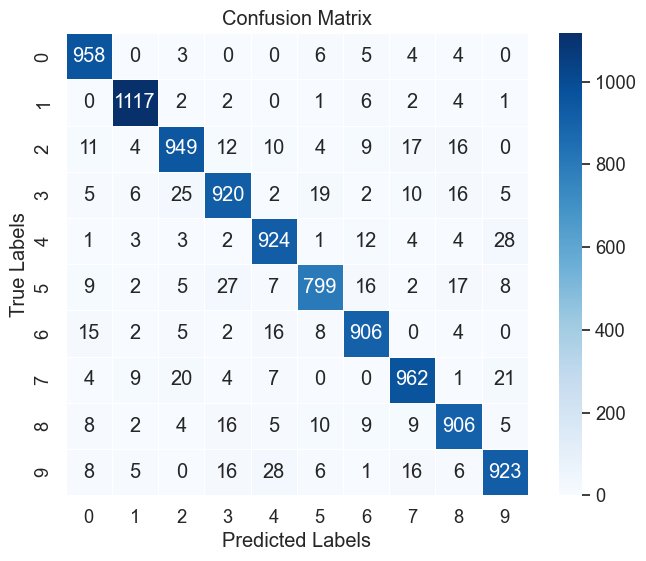

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import datasets

# Compute the confusion matrix
confusion_mat = confusion_matrix(Y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', linewidths=.5, square=True)

# Set axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


### The accuracy for the models

| Person   | Learning rate | Mini-batch size | Acc(validation) | Time (m, s) |
|----------|---------------|-----------------|-----------------|-------------|
| Jacob    | 0.1           | 8               |                 |             |
| Jacob    | 0.7           | 8               |                 |             |
| Jacob    | 0.01          | 8               |                 |             |
| Jacob    | 0.7           | 1               |                 |             |
| Lina     | 0.1           | 32              |                 |             |
| Lina     | 0.7           | 32              |                 |             |
| Lina     | 0.01          | 32              |                 |             |
| Lina     | 0.01          | 1               |                 |             |
| Dumitra  | 0.1           | 64              |                 |             |
| Dumitra  | 0.7           | 64              |                 |             |
| Dumitra  | 0.01          | 64              |                 |             |
| Filippa  | 0.1           | 1               | 0.9432          | 13m 17.2s   |
| Filippa  | 0.1           | 128             | 0.9459          | 0m 33.0s    |
| Filippa  | 0.7           | 128             | 0.1022          | 0m 31.7s    |
| Filippa  | 0.01          | 128             | 0.9364          | 0m 34.8s    |
| Marko    | 0.1           | 256             |                 |             |
| Marko    | 0.7           | 256             |                 |             |
| Marko    | 0.01          | 256             |                 |             |
